In [1]:
# ======== a runnable full training procedure =========
# resnet18 + adam ,test acc ~ 99.1%
import sys
sys.path.append(r'/kaggle/input/dezero')
from imp import reload
import dezero

from dezero import Variable
import dezero.functions as F
reload(F)
import numpy as np
import matplotlib.pyplot as plt


from dezero import optimizers
reload(optimizers)
from dezero import DataLoader
# from dezero.models import MLP
from dezero import models
reload(models)
# from dezero.models import ResNet18, MLP, C5L3
from dezero.datasets import Dataset

# we can use torch's data loader
import torch
import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms
# from torchvision import transforms

if torch.cuda.is_available():
    run_on_local = False
else:
    run_on_local = True
    

C:\Users\xuguy\AppData\Local\Temp\ipykernel_29272\3695756298.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


No module named 'cupy'


In [8]:
# ======= prepare data ========

# setup hyper-params
max_epoch = 100
batch_size = 64
model_id = 0
data_aug = 1
modelnames = ['C5L4', 'ResNet18']

lr = 0.001
hidden_size = 1000
print_every = 1

# load with pickle
# we download the mnist dataset and store it in .pkl
import pickle
# delete this line if kaggle-gpu is available
# run_on_local = False

if run_on_local:
    filepath = r'./dezero/MNISTdataset/mnist.pkl'
    num_workers = 0
else:
    filepath = r'/kaggle/input/dezero/dezero/MNISTdataset/mnist.pkl'
    num_workers = 2

print(filepath)
with open(filepath, 'rb') as f:
    data = pickle.load(f)

# we only use tv_transform to transform the ndarray data
if data_aug:
    # g = tv_transforms.Compose([

    #                 # tv_transforms.ToTensor(),
    #                 tv_transforms.RandomRotation(15),  
    #                 # tv_transforms.RandomHorizontalFlip(),
    #                 tv_transforms.RandomAffine(0, translate=(0.1, 0.1)),  
    #                 # tv_transforms.RandomResizedCrop(28, scale=(0.9, 1.1)), 
    #                 # tv_transforms.ToTensor(),  
    #                 tv_transforms.Normalize((0.1307,), (0.3081,))
    #                 ])  

    g = tv_transforms.Compose([

                    # tv_transforms.ToTensor(),
                    tv_transforms.RandomRotation(15),  
                    tv_transforms.RandomHorizontalFlip(),
                    tv_transforms.RandomAffine(0, translate=(0.1, 0.1)),  
                    # tv_transforms.RandomResizedCrop(28, scale=(0.9, 1.1)), 
                    # tv_transforms.ToTensor(),  
                    tv_transforms.Normalize((0.1307,), (0.3081,))
                    ])  
    def f(x):
        # return g(torch.tensor(x, dtype=torch.float32))
        return g(x)
else:
    def f(x):
        # x = x.flatten()
        x = x.astype(np.float32)
        x /= 255.0
        return x

test_set = Dataset()
test_set.transform = f
test_set.data= data['test_img'].reshape(-1, 1, 28, 28)
test_set.label = data['test_label']
print(f'{test_set.data.shape}, {test_set.label.shape}')


train_set = Dataset()
train_set.transform = f
train_set.data= data['train_img'].reshape(-1, 1, 28, 28)
train_set.label = data['train_label']
print(f'{train_set.data.shape}, {train_set.label.shape}')

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle = False)


./dezero/MNISTdataset/mnist.pkl
(10000, 1, 28, 28), (10000,)
(60000, 1, 28, 28), (60000,)


C:\Users\xuguy\AppData\Local\Temp\ipykernel_29272\2303031117.py:29: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


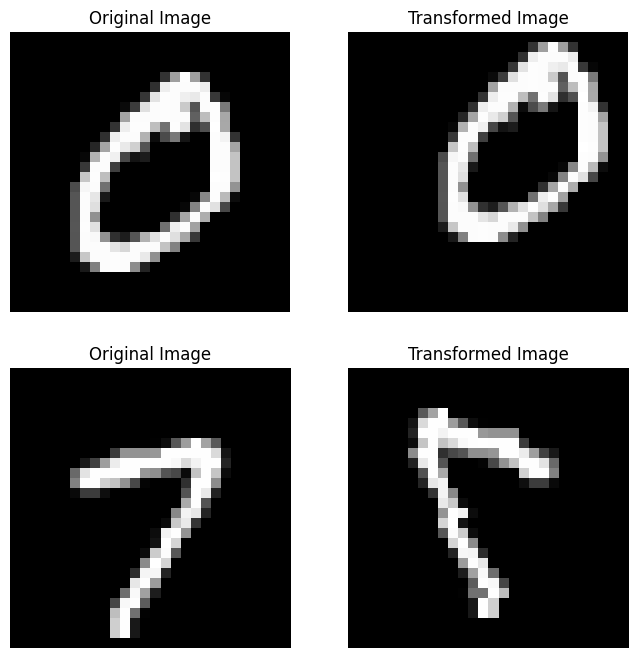

finish plotting transformed img


In [21]:
# original image
img_arr = data['train_img'][1].reshape(-1, 28, 28)
img_arr_2 = data['train_img'][103].reshape(-1, 28, 28)

# transformed image
img_arr_transformed = f(torch.tensor(img_arr, dtype=torch.float32))
img_arr2_transformed = f(torch.tensor(img_arr_2, dtype=torch.float32))
# img_arr_transformed = f(img_arr)
# img_arr2_transformed = f(img_arr_2)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # 
# show ori image
axes[0,0].imshow(img_arr.squeeze(), cmap='gray')
axes[0,0].axis('off')
axes[0,0].set_title("Original Image")

# show transformed img
axes[0,1].imshow(img_arr_transformed.squeeze(), cmap='gray')
axes[0,1].axis('off')
axes[0,1].set_title("Transformed Image")

# show ori image
axes[1,0].imshow(img_arr_2.squeeze(), cmap='gray')
axes[1,0].axis('off')
axes[1,0].set_title("Original Image")

# show transformed img
axes[1,1].imshow(img_arr2_transformed.squeeze(), cmap='gray')
axes[1,1].axis('off')
axes[1,1].set_title("Transformed Image")

plt.show()

print('finish plotting transformed img')

In [ ]:
# train

N = len(train_set)
# model = MLP((1000,10))
# model = ResNet18(pretrained=False)
model = getattr(models, modelnames[model_id])()
# model = MLP((1000, 10), activation= F.leaky_relu)
# Adam works
optimizer = optimizers.Adam().setup(model)
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    test_loader.to_gpu()
    model.to_gpu()

train_avg_loss = []
train_avg_acc = []

test_avg_loss = []
test_avg_acc = []


# try to load weights (check if path exists)
# if os.path.exists('my_mlp.npz'):
#     model.load_weights('my_mlp.npz')

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        acc = F.accuracy(y, t)
        optimizer.update()
        sum_loss += float(loss.data)*len(t)
        sum_acc += float(acc.data) * len(t)


    # print training info
    train_avg_loss.append(sum_loss / len(train_set))
    train_avg_acc.append(sum_acc / len(train_set))
    # if epoch % print_every == print_every-1 :
    print(f'epoch: {epoch+1}, train_avg_loss: {train_avg_loss[-1]:.3f}, train_avg_acc: {train_avg_acc[-1]:.3f}')

    sum_loss, sum_acc = 0, 0
    # print eval info
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            # loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    
    # print eval(test) info
    test_avg_loss.append(sum_loss / len(test_set))
    test_avg_acc.append(sum_acc / len(test_set))
    # if epoch % print_every == print_every-1 :
    # print(f'test_avg_loss: {avg_loss:.4f}, test_avg_acc: {avg_acc:.4f}')
    print(f'train_loss:{train_avg_loss[-1]:.3f}, test_loss:{test_avg_loss[-1]:.3f}, test_acc: {test_avg_acc[-1]:.3f}')

print('====== finish training ======')

In [ ]:
# save weights/training stats and visualize

save_name = f'{modelnames[model_id]}_{int(data_aug)}aug'
PATH = '/kaggle/working/'+ 'weights_' + save_name +'.npz'
model.save_weights(PATH)

# save accuracy/loss statistics
np.save('stats_' + save_name+'_accuracy_test.npy', np.array(test_avg_acc))
np.save('stats_' + save_name+'_loss_train.npy', np.array(train_avg_loss))
np.save('stats_' + save_name+'_loss_test.npy', np.array(test_avg_loss))


import matplotlib.pyplot as plt

def visualize_accuracy(accuracy_test, loss_test, loss_train, save_path):
    import matplotlib.gridspec as gridspec

    plt.figure(figsize=(10, 10))  
    gs = gridspec.GridSpec(2, 2,  
                        height_ratios=[5, 5], 
                        width_ratios=[5, 5],   
                        hspace=0.2, wspace=0.2)  

    
    ax1 = plt.subplot(gs[0, 0])  
    ax2 = plt.subplot(gs[0, 1])  
    ax3 = plt.subplot(gs[1, :])  

    
    ax1.plot(loss_train, marker='o', linestyle='-', color='g', label='Train Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss Value')
    ax1.set_title('Training Loss Progression')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(0, len(loss_train))  
    ax1.set_ylim(min(loss_train)*0.9, max(loss_train)*1.1)  

    
    ax2.plot(loss_test, marker='o', linestyle='-', color='r', label='Test Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss Value')
    ax2.set_title('Validation Loss Progression')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xlim(0, len(loss_test))   
    ax2.set_ylim(min(loss_test)*0.9, max(loss_test)*1.1)  

    
    ax3.plot(accuracy_test, marker='o', linestyle='-', color='b', label='Test Accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Model Prediction Accuracy')
    ax3.legend()
    ax3.grid(True)
    ax3.set_xlim(0, len(accuracy_test))  
    ax3.set_ylim(min(accuracy_test)*0.95, 100 if max(accuracy_test)>95 else max(accuracy_test)*1.05)  

    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

visualize_accuracy(test_avg_acc, test_avg_loss, train_avg_loss, 'train_result.png')

In [ ]:
# # visualize image after transform
# import matplotlib.pyplot as plt
# import numpy as np

# # remove batch dim to get an array of shape (28, 28)
# img_arr = data['train_img'][1].reshape(-1,28,28)

# img_arr = f(torch.tensor(img_arr, dtype = torch.float32))
# # image = image_array.squeeze()

# # 展示图像
# plt.imshow(img_arr.squeeze(), cmap='gray')  # gray projection
# plt.axis('off')  # turn off axis
# plt.show()


# ======= commpare image before and after transform ========
# # visualize image after transform


# # original image:
# img_arr = data['train_img'][1].reshape(-1,28,28)
# plt.imshow(img_arr.squeeze(), cmap='gray')  # gray projection
# plt.axis('off')  # turn off axis
# plt.show()

# img_arr = f(torch.tensor(img_arr, dtype = torch.float32))
# # image = image_array.squeeze()

# # image after transform:
# plt.imshow(img_arr.squeeze(), cmap='gray')  # gray projection
# plt.axis('off')  # turn off axis
# plt.show()


# ============================================================
# # part 2, try to repeat C5L3 using dezero framework.abs
# reload(dezero.models)
# from dezero.models import C5L3
# model = C5L3()
# x = train_set.data[1].reshape(1,1,28,28)
# model(x)